/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning_utilities/core/imports.py:14: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/pkg_resources/__init__.py:2317: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptoo

tensor([-75., -77., -37.])


/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


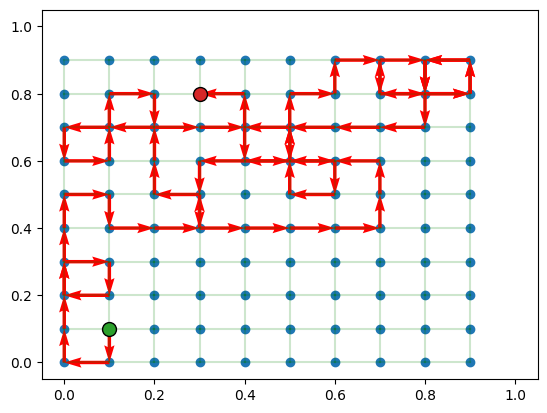

In [1]:
from SPPenv import SPPEnv
from utils import rollout, random_policy

batch_size = 3

env = SPPEnv(num_loc=100)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

In [2]:
from astar import AStarSearch
# from SPPenv import SPPEnv
from SPPenv import SPPEnv
import torch

env = SPPEnv(num_loc=100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
astar = AStarSearch(td_init)
actions_astar = astar.search()
print(actions_astar)

{'actions': tensor([[13, 14, 15, 16, 26, 36, 46],
        [ 4,  5,  6,  7,  7,  7,  7],
        [25, 15,  5,  4,  4,  4,  4]]), 'reward': tensor([-6., -3., -3.])}


In [3]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy

env = SPPEnv(num_loc=100)

# from SPPv2env import SPPv2Env
# env = SPPv2Env(num_loc=100)

# Instantiate policy with the embeddings we created above
emb_dim = 64
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=SPPInitEmbedding(emb_dim),
                              context_embedding=SPPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

# policy = POMOPolicy(env,
#                     embedding_dim=emb_dim,
#                     init_embedding=SPPInitEmbedding(emb_dim),
#                     context_embedding=SPPContext(emb_dim),
#                     dynamic_embedding=StaticEmbedding(emb_dim))

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=100,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_00,
                       val_data_size=100_0,)

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 1000.000
Problem 2 | Cost: 25.000
Problem 3 | Cost: 18.000


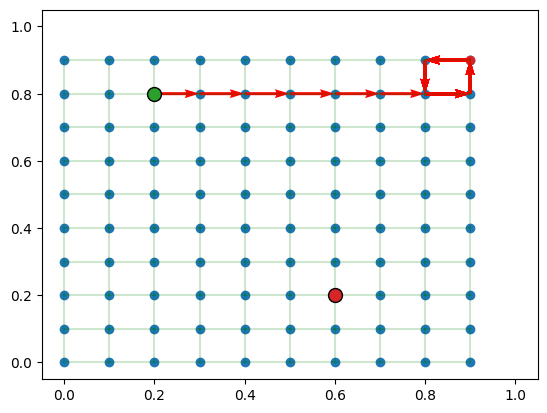

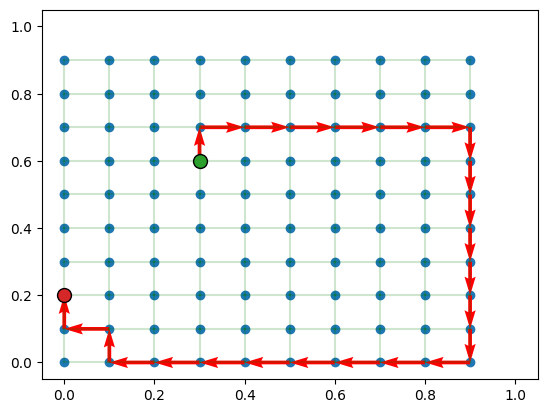

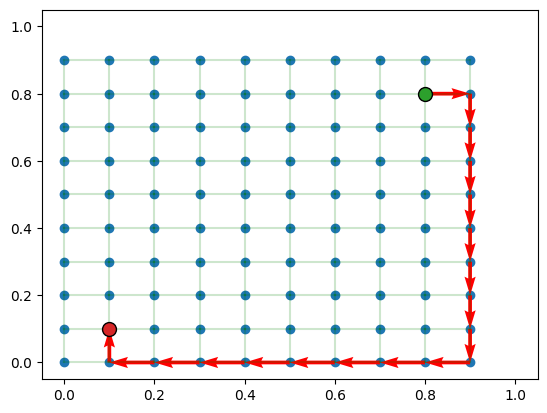

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [5]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SPPEnv               | 0     
1 | policy   | AutoregressivePolicy | 278 K 
2 | baseline | WarmupBaseline       | 278 K 
--------------------------------------------------
556 K     Trainable

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s, v_num=257, train/reward=-8.25, train/loss=-37.5, val/reward=-6.54]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s, v_num=257, train/reward=-8.25, train/loss=-37.5, val/reward=-6.54]


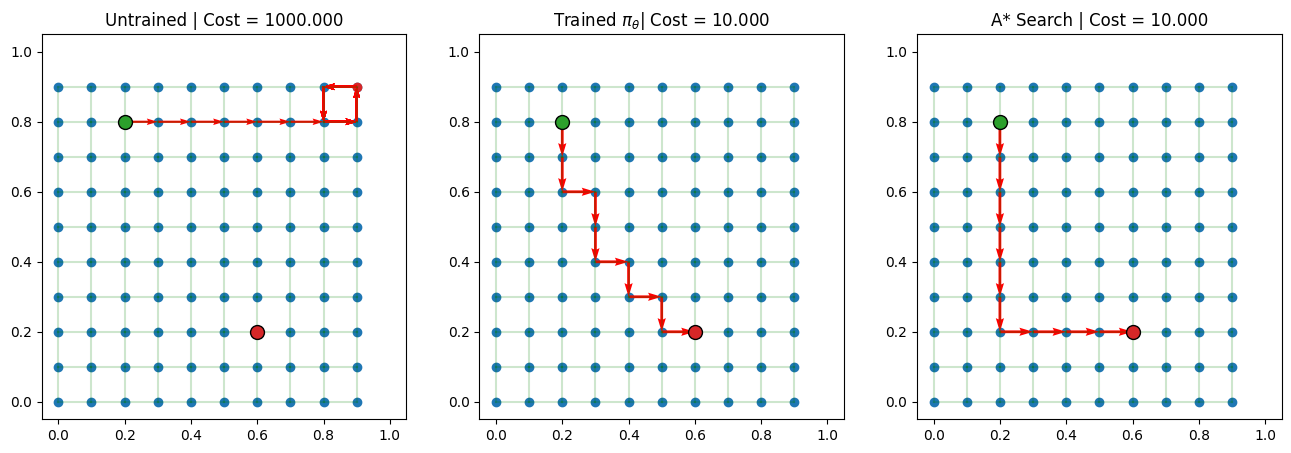

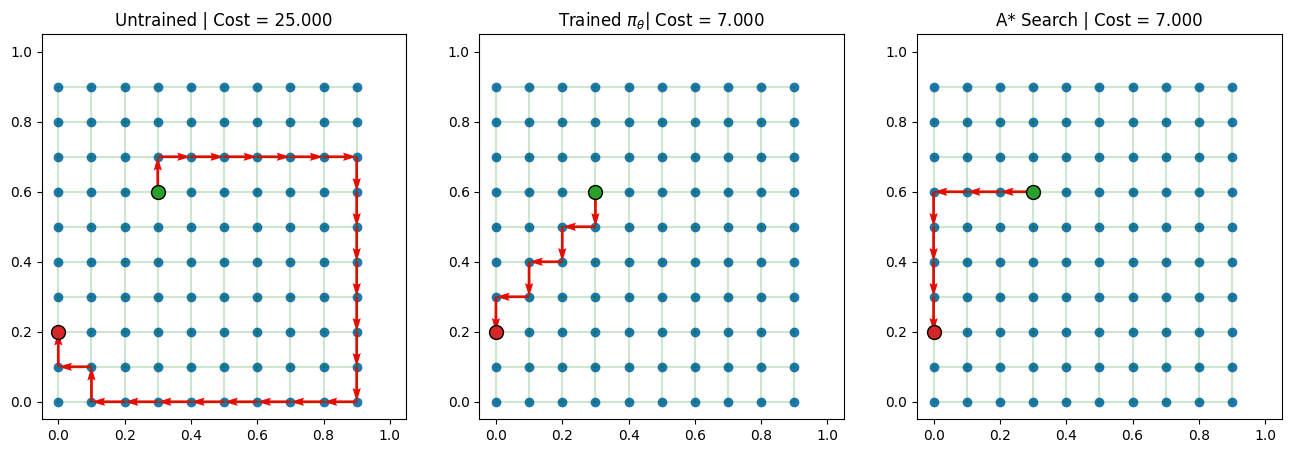

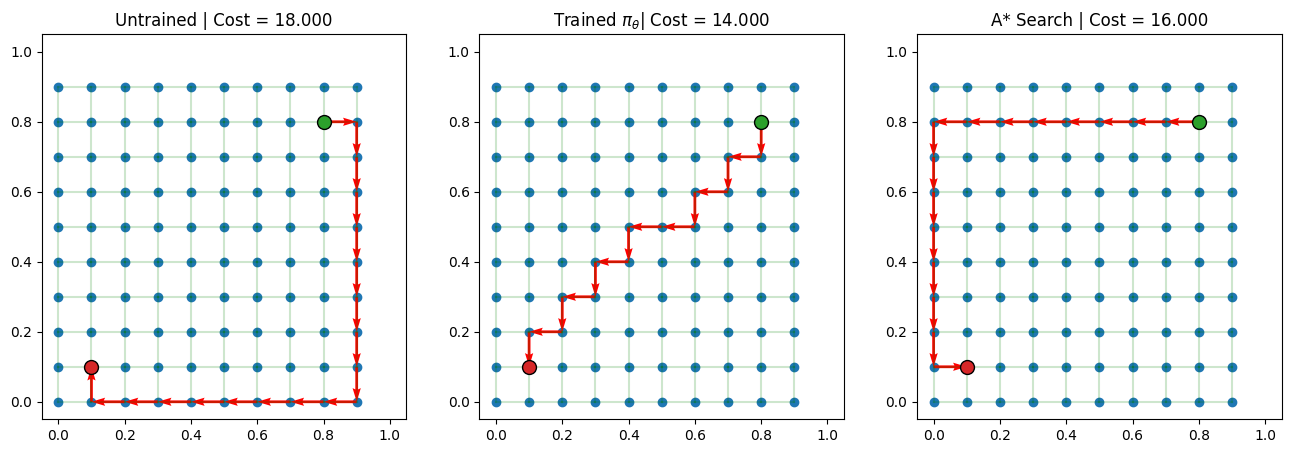

In [6]:
# infer_env = SPPEnv(num_loc=500)
#from SPPenv import SPPEnv
#infer_env = SPPDynamicEnv(num_loc=100)
# infer_env = SPPEnv(num_loc=100)

# td_init = env.reset(batch_size=[3]).to(device)

# model = model.to(device)
# out = model(td_init.clone(),env=env, phase="test", decode_type="greedy", 
# return_actions=True)
# actions_trained = out['actions'].cpu().detach()

policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")

    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    env.render(td, actions_astar[i], ax=axs[2])
    axs[2].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

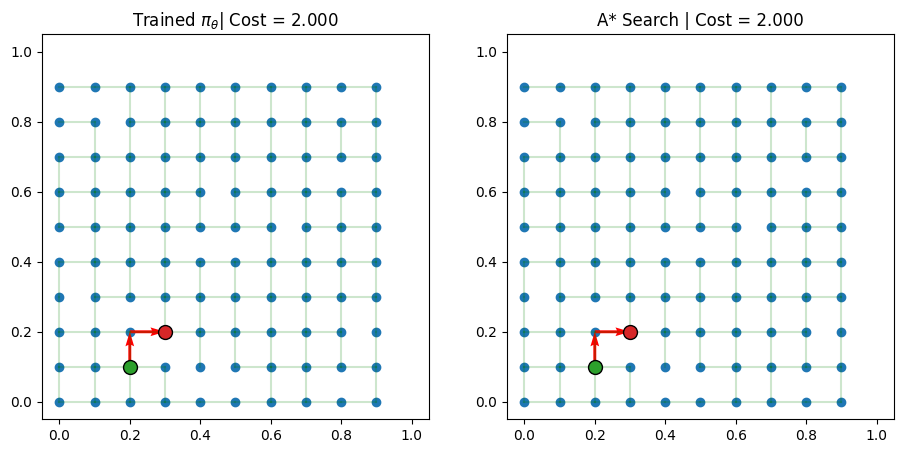

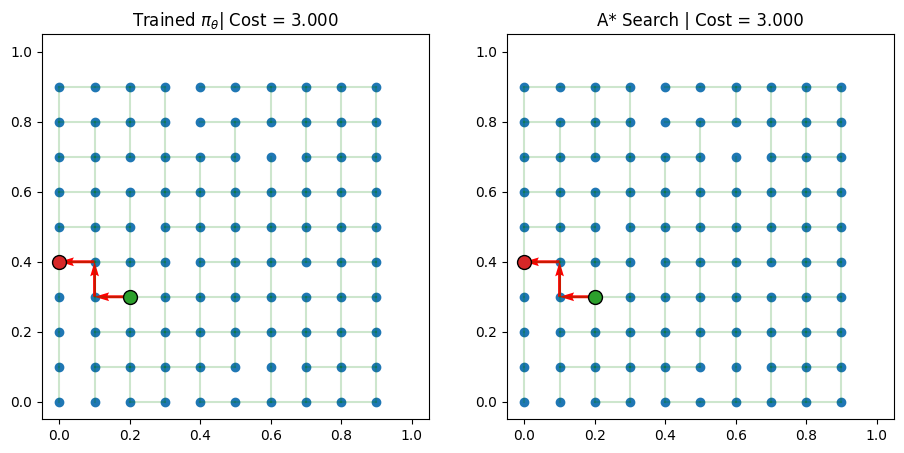

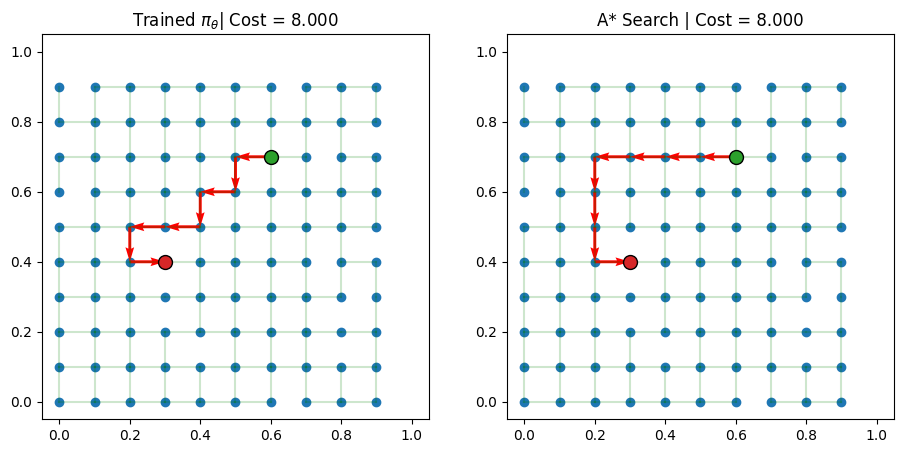

In [7]:
from SPPv2env import SPPv2Env

infer_env = SPPv2Env(num_loc=100)
td_init = infer_env.reset(batch_size=[3]).to(device)

policy = model.policy.to(device)
out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

In [8]:
import numpy as np
# Initialize the total costs
total_cost_trained = 0
total_cost_astar = 0
cost_list_trained = np.array([])
cost_list_astar = np.array([])

# Number of runs
num_runs = 100

batch_size = 10

# Initialize the action lists
actions_trained = []
actions_astar = []

# Initialize the TensorDict list
td_list = []

for _ in range(num_runs):
    while True:
        try:
            # Initialize the action lists for the current run
            actions_trained_run = []
            actions_astar_run = []

            # infer_env = SPPEnv(num_loc=100)
            # td_init = infer_env.reset(batch_size=[batch_size]).to(device)
            
            infer_env = SPPv2Env(num_loc=100)
            td_init = infer_env.reset(batch_size=[batch_size]).to(device)

            # Run the trained DRL model
            out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
            total_cost_trained += out['reward'].sum().item()

            # Run A* search
            astar = AStarSearch(td_init.clone())
            astar_out = astar.search()
            total_cost_astar += astar_out["reward"].sum().item()

            # Store the TensorDict
            td_list.append(td_init)
            
            # Store the output of the astar and trained model
            actions_trained.append(out["actions"].cpu().detach())
            actions_astar.append(astar_out["actions"].cpu().detach())

            # Store the cost of the trained model and A* search
            cost_list_trained = np.append(cost_list_trained, out["reward"].cpu().detach().numpy())
            cost_list_astar = np.append(cost_list_astar, astar_out["reward"].cpu().detach().numpy())

            break
        except:
            continue

    # Append the action lists for the current run to the overall action list
    # actions_trained.append(actions_trained_run)
    # actions_astar.append(actions_astar_run)

# How many -1000 rewards are there in the trained DRL model
nosols_trained = np.sum(cost_list_trained == -1000)
print(f"Number of unsolved problems in trained DRL model: {nosols_trained}")

# Remove all the -1000 rewards
cost_list_trained_filtered = cost_list_trained[cost_list_trained != -1000]

Number of unsolved problems in trained DRL model: 18


Mean cost of trained DRL model over 1000 runs: -7.107
Mean cost of A* search over 1000 runs: -7.572
Median cost of trained DRL model over 1000 runs: -7.000
Median cost of A* search over 1000 runs: -7.000
Standard deviation of trained DRL model over 1000 runs: 3.636
Standard deviation of A* search over 1000 runs: 3.842


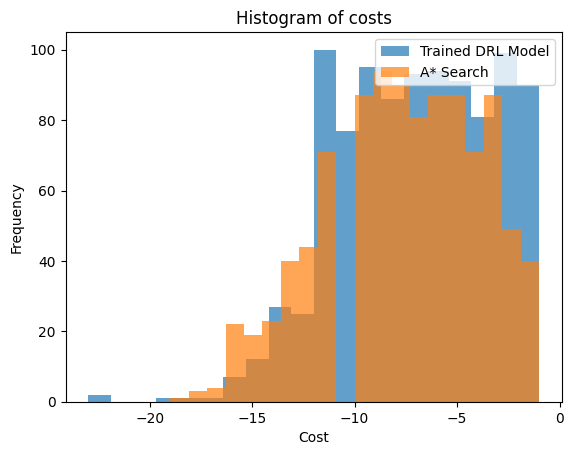

[398  31 790]
[-18. -18. -19.]
39 8
3 1
79 0
[975 613 662]
97 5
61 3
66 2


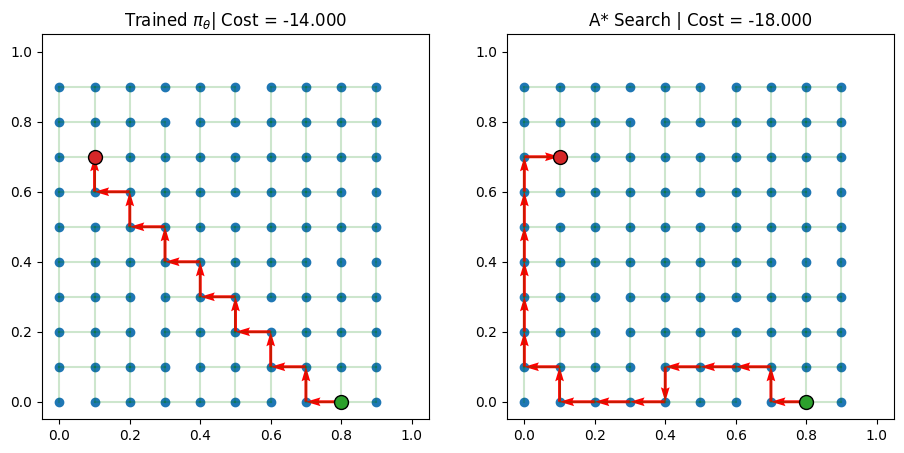

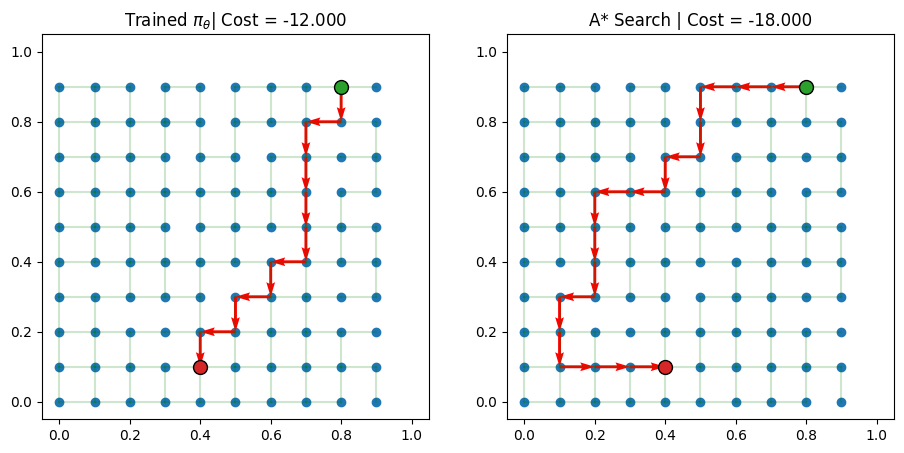

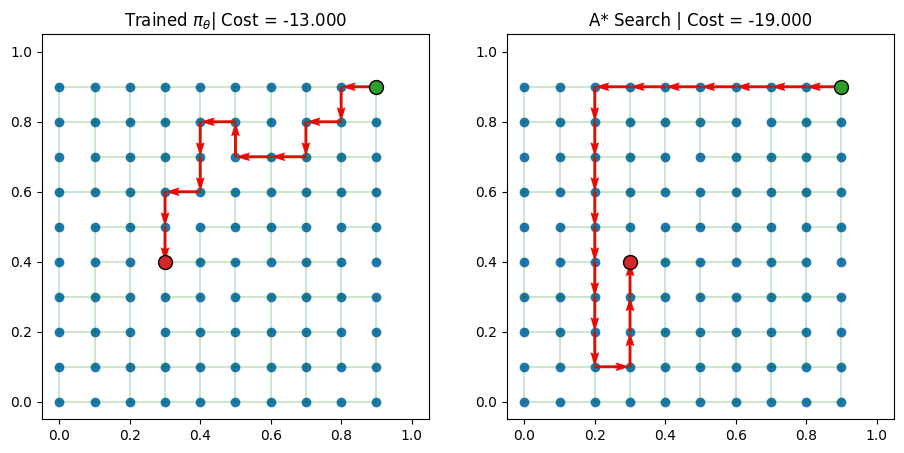

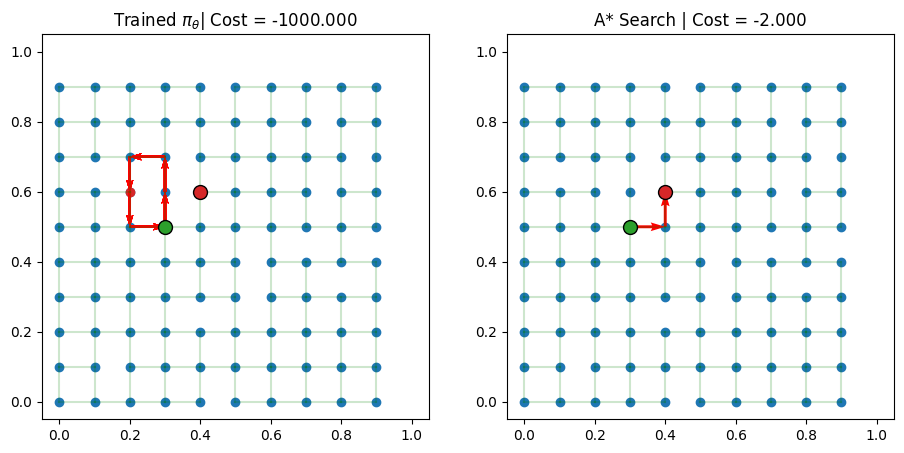

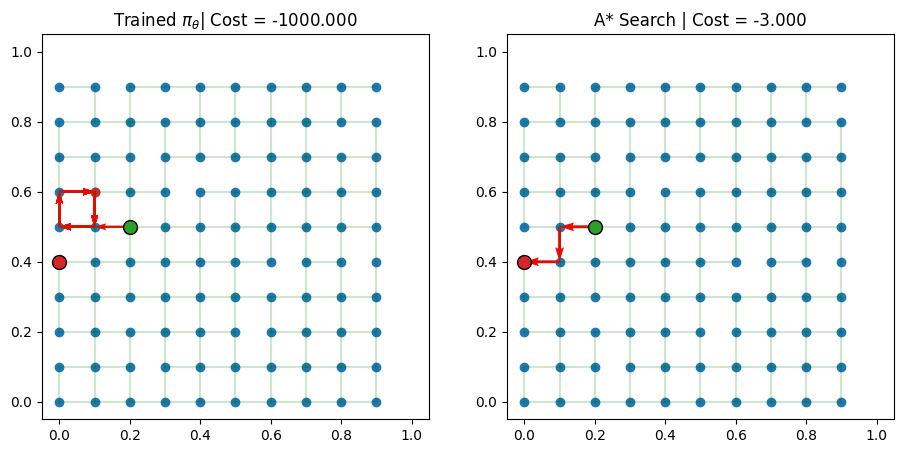

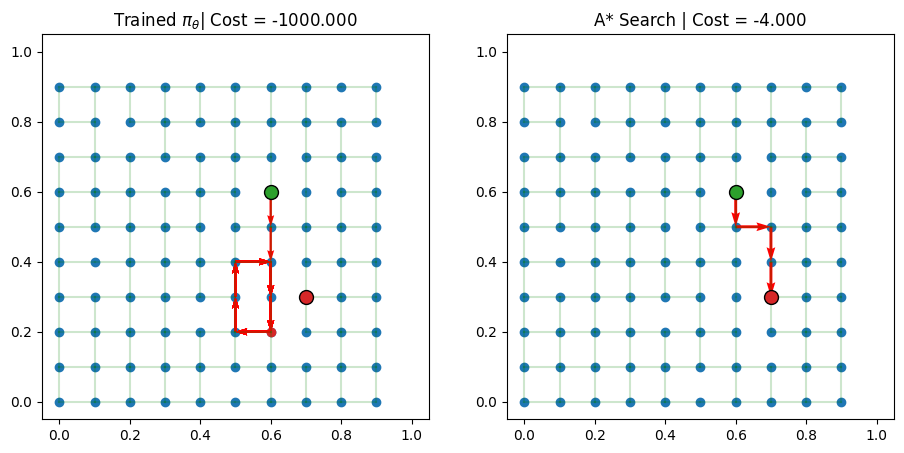

In [9]:
# Calculate the average costs
print ("Mean cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.mean()))
print ("Mean cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.mean()))

# Calculate the mean and standard deviation of the costs
print ("Median cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_trained_filtered)))
print ("Median cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_astar)))
print ("Standard deviation of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.std()))
print ("Standard deviation of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.std()))

# Plot the histogram of the costs
plt.hist(cost_list_trained_filtered, bins=20, alpha=0.7, label='Trained DRL Model')
plt.hist(cost_list_astar, bins=20, alpha=0.7, label='A* Search')
plt.legend(loc='upper right')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Histogram of costs')
plt.show()

# Get the indices of the runs with the highest costs
worst_runs = np.argsort(cost_list_astar)[::-1][-3:]
print(worst_runs)
print(cost_list_astar[worst_runs])

# Plot the actions for the first run
import matplotlib.pyplot as plt

for run in worst_runs:
    quotient, remainder = divmod(run, batch_size)
    print(quotient, remainder)
    for i, td in enumerate(td_list[quotient]):
        if i == remainder:
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            try:
                infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
                axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
            except Exception as e:
                print(e)
                print("Error in plotting trained model")
                pass

            infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))

# Plot the actions with the largest difference between the trained model and A* search
diff = - cost_list_trained + cost_list_astar
largest_diffs = np.argsort(diff)[::-1][:3]
print(largest_diffs)

for run in largest_diffs:
    quotient, remainder = divmod(run, batch_size)
    print(quotient, remainder)
    for i, td in enumerate(td_list[quotient]):
        if i == remainder:
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            try:
                infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
                axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
            except Exception as e:
                print(e)
                print("Error in plotting trained model")
                pass

            infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))